# Setup of the environment

In [ ]:
!pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.6 MB/s eta 0:00:00


Importing the neccessary libraries

In [ ]:
import torch
import monai
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from monai.networks.nets import unet
from monai.networks.blocks import Warp, DVF2DDF
from monai.config import USE_COMPILED
from tqdm import tqdm
from torch.nn import MSELoss
import numpy as np

Here we define a PyTorch loss function called **GradEnergyLoss** that calculates the **Gradient** **Energy** **loss** based on the **first-order differentiation** of the predicted tensor using **forward finite difference**. This loss is commonly used in image processing tasks.

The GradEnergyLoss class inherits from _Loss, which is the base class for all PyTorch loss functions. It overrides the forward method to compute the loss value.

The spatial_gradient function calculates the gradients on a single dimension of a tensor using central finite difference. It takes a tensor x and a dimension dim as input and returns the gradient tensor. The gradient is calculated as dx[i] = (x[i+1] - x[i-1]) / 2. The function is adapted from the DeepReg library.

The implementation of the forward method calculates the first-order gradient of the predicted tensor using the spatial_gradient function, which uses central finite difference. The gradient is calculated along each spatial dimension.

The energy is then computed by summing the squared values of the first-order gradients.

In [ ]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Union

import torch
from torch.nn.modules.loss import _Loss

from monai.utils import LossReduction


def spatial_gradient(x: torch.Tensor, dim: int) -> torch.Tensor:
    """
    Calculate gradients on single dimension of a tensor using central finite difference.
    It moves the tensor along the dimension to calculate the approximate gradient
    dx[i] = (x[i+1] - x[i-1]) / 2.
    Adapted from:
        DeepReg (https://github.com/DeepRegNet/DeepReg)

    Args:
        x: the shape should be BCH(WD).
        dim: dimension to calculate gradient along.
    Returns:
        gradient_dx: the shape should be BCH(WD)
    """
    slice_1 = slice(1, -1)
    slice_2_s = slice(2, None)
    slice_2_e = slice(None, -2)
    slice_all = slice(None)
    slicing_s, slicing_e = [slice_all, slice_all], [slice_all, slice_all]
    while len(slicing_s) < x.ndim:
        slicing_s = slicing_s + [slice_1]
        slicing_e = slicing_e + [slice_1]
    slicing_s[dim] = slice_2_s
    slicing_e[dim] = slice_1 #slice_2_e
    return (x[slicing_s] - x[slicing_e])# / 2.0


class GradEnergyLoss(_Loss):
    """
    Calculate the Grad energy based on first-order differentiation of pred using forward finite difference.

    Adapted from:
        DeepReg (https://github.com/DeepRegNet/DeepReg)
    """

    def __init__(self, normalize: bool = False, reduction: Union[LossReduction, str] = LossReduction.MEAN) -> None:
        """
        Args:
            normalize:
                Whether to divide out spatial sizes in order to make the computation roughly
                invariant to image scale (i.e. vector field sampling resolution). Defaults to False.
            reduction: {``"none"``, ``"mean"``, ``"sum"``}
                Specifies the reduction to apply to the output. Defaults to ``"mean"``.

                - ``"none"``: no reduction will be applied.
                - ``"mean"``: the sum of the output will be divided by the number of elements in the output.
                - ``"sum"``: the output will be summed.
        """
        super().__init__(reduction=LossReduction(reduction).value)
        self.normalize = normalize

    def forward(self, pred: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: the shape should be BCH(WD)

        Raises:
            ValueError: When ``self.reduction`` is not one of ["mean", "sum", "none"].

        """
        if pred.ndim not in [3, 4, 5]:
            raise ValueError(f"Expecting 3-d, 4-d or 5-d pred, instead got pred of shape {pred.shape}")
        for i in range(pred.ndim - 2):
            if pred.shape[-i - 1] <= 4:
                raise ValueError(f"All spatial dimensions must be > 4, got spatial dimensions {pred.shape[2:]}")
        if pred.shape[1] != pred.ndim - 2:
            raise ValueError(
                f"Number of vector components, {pred.shape[1]}, does not match number of spatial dimensions, {pred.ndim-2}"
            )

        # first order gradient
        first_order_gradient = [spatial_gradient(pred, dim) for dim in range(2, pred.ndim)]

        # spatial dimensions in a shape suited for broadcasting below
        if self.normalize:
            spatial_dims = torch.tensor(pred.shape, device=pred.device)[2:].reshape((1, -1) + (pred.ndim - 2) * (1,))

        energy = 0

        for dim in range(len(first_order_gradient)):
          energy += first_order_gradient[dim] ** 2

        if self.reduction == LossReduction.MEAN.value:
            energy = torch.mean(energy)  # the batch and channel average
        elif self.reduction == LossReduction.SUM.value:
            energy = torch.sum(energy)  # sum over the batch and channel dims
        elif self.reduction != LossReduction.NONE.value:
            raise ValueError(f'Unsupported reduction: {self.reduction}, available options are ["mean", "sum", "none"].')

        return energy


In [ ]:
def rescale_image(image):
    # Multiply the image by 255 to scale the pixel values
    rescaled_image = (image * 255)
    return rescaled_image


# Data

We're going to start by registering 2D MNIST digits, and then move on to medical data later.

First, we're going to select which 2D MNIST digit and **load the data** in moving image and fixed images



downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Shape of x_faces: (400, 64, 64)
Shape of y_faces: (400,)


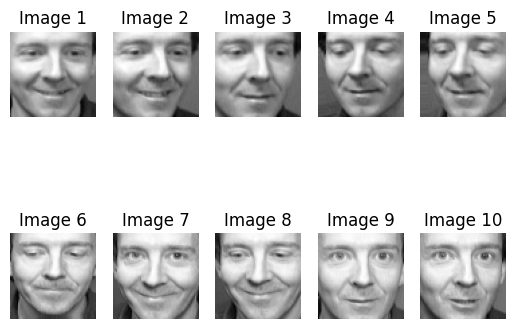

In [ ]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_olivetti_faces

faces_dataset = fetch_olivetti_faces()

x_faces = faces_dataset.images
y_faces = faces_dataset.target

print('Shape of x_faces:', x_faces.shape)
print('Shape of y_faces:', y_faces.shape)

person_id = 2

person_images = x_faces[y_faces == person_id]

#print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

fixed = np.float32(person_images)
#fixed=fixed[None,:,:]
moving = np.float32(person_images[0])

fixed = resize(fixed,(fixed.shape[0],64,64))
moving = 0*resize(moving,(64,64))   #initialising the moving image to 0

fixed = rescale_image(fixed)
moving = rescale_image(moving)

fig, axes = plt.subplots(2, 5)
for i, ax in enumerate(axes.flat):
    ax.imshow(fixed[i], cmap='gray')
    ax.axis('off')
    ax.set_title('Image {}'.format(i+1))

plt.show()


In [ ]:
fixed.shape


(10, 64, 64)

In [ ]:
moving.shape

(64, 64)

In [ ]:
fixed.shape[0]

10

These functions are for labelling the image and displaying it side by side

In [ ]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        #cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')

        im=list_axes[i].imshow(img, cmap='gray', vmin=0, vmax=255)

        plt.colorbar(im,fraction=0.046, pad=0.04)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)


    fig.tight_layout()
    _=plt.show()


Visualising the stored 2D MNIST datas (out of all the fixed datas we are just displaying 5 of them):




In [ ]:
'''nofixed=5
list_images=[moving]
name=['Fixed Image']
list_titles=list(np.repeat(name,nofixed))
for i in range(nofixed):
  list_images.append(fixed[i])
show_image_list(list_images=list_images,
                list_titles=['Moving Image']+list_titles,
                num_cols=2,
                figsize=(10, 10),
                grid=False,
                title_fontsize=15)'''


Average of all the fixed images

Text(0.5, 1.0, 'Average Image')

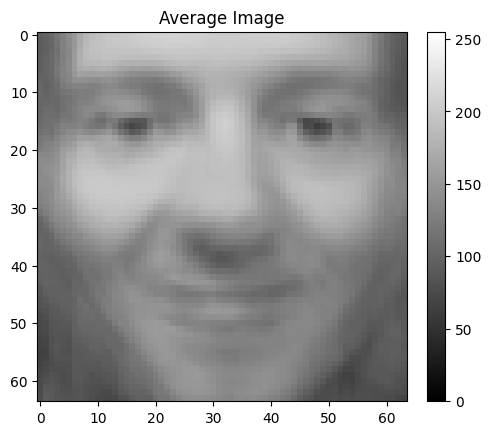

In [ ]:
sum=0
for i in range(10):
  sum+=fixed[i]

avg_fixed=sum/10
plt.imshow(avg_fixed,vmin=0, vmax=255,cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Average Image')

Implementing a registration framework using a U-Net architecture.

We set up a U-Net-based registration framework with separate models for registration (reg) and the moving image (moving_net). It initializes the optimizers for each model and sets them in training mode.

In [ ]:
reg = unet.UNet(spatial_dims=2,  # spatial dims
    in_channels=2,
    out_channels=2,# output channels (to represent 2D displacement vector field)
    channels=(16, 32, 32, 32, 32),  # channel sequence
    strides=(1, 2, 2, 4),  # convolutional strides
    dropout=0.2,
    norm="batch").to('cuda')

if USE_COMPILED:
    warp_layer = Warp(2, padding_mode="zeros").to('cuda')
else:
    warp_layer = Warp("bilinear", padding_mode="zeros").to('cuda')

dvf_2_ddf = DVF2DDF()

reg.train()
optimizerR = torch.optim.Adam(reg.parameters(), lr=0.01)

import torch.nn as nn

class Model(nn.Module):
    def __init__(self, img):
        super(Model, self).__init__()
        self.moving_img = nn.Parameter(img)

    def forward(self):
        return self.moving_img


moving_net = Model(torch.tensor(0*moving)).to('cuda')
optimizerM = torch.optim.Adam(moving_net.parameters(), lr=0.1)
moving_net.train()

/usr/local/lib/python3.10/dist-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


Model()

The Loss function and regularization is implemented:

In [ ]:
image_loss = MSELoss()
regularization_loss = GradEnergyLoss()
image_loss.to('cuda')

MSELoss()

In [ ]:
print(moving.shape)
print(fixed.shape)
fixedo = fixed.copy()
movingo=moving.copy()

(64, 64)
(10, 64, 64)


In [ ]:
moving = moving_net()
print(moving[None,None,:,:].shape)


print(torch.tile(moving[None,None,:,:],(fixed.shape[0],1,1,1)).shape)


torch.Size([1, 1, 64, 64])
torch.Size([10, 1, 64, 64])


# Training loop for the registration model  




In [ ]:
fixed = fixedo[:,None,:,:]
#moving = np.tile(movingo,(fixed.shape[0],1,1,1))

max_epochs = 50000

loss_array=[]
epoch_array=[]

fixed = torch.tensor(fixed).to('cuda')

for epoch in tqdm(range(max_epochs)):

    optimizerM.zero_grad()
    optimizerR.zero_grad()

    moving1 = moving_net()
    moving = torch.tile(moving1[None,None,:,:],(fixed.shape[0],1,1,1))
    input_data = torch.cat((moving, fixed), dim=1)

    dvf = reg(input_data)
    ddf = dvf_2_ddf(dvf)
    moved = warp_layer(moving, ddf)

    imgloss = image_loss(moved, fixed) + 6000*regularization_loss(ddf)

    imgloss.backward()
    optimizerR.step()
    optimizerM.step()

    loss_value=imgloss.item()
    loss_array.append(loss_value)
    epoch_array.append(epoch)
    #print(f"Epoch: {epoch}, Loss: {loss_value}")





100%|██████████| 50000/50000 [14:53<00:00, 55.96it/s]


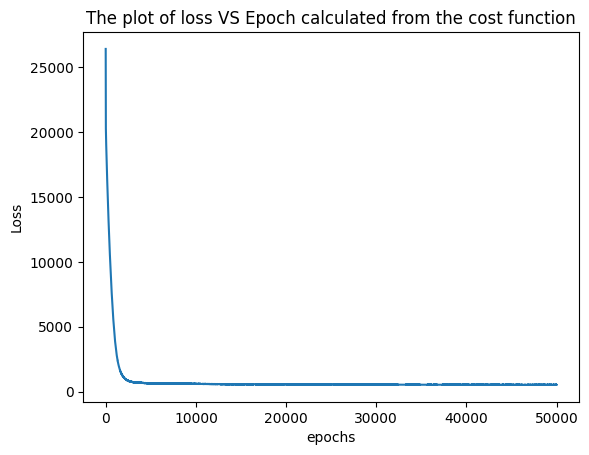

In [ ]:
plt.plot(epoch_array,loss_array)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('The plot of loss VS Epoch calculated from the cost function')
plt.show()

Visualising the results after warping:

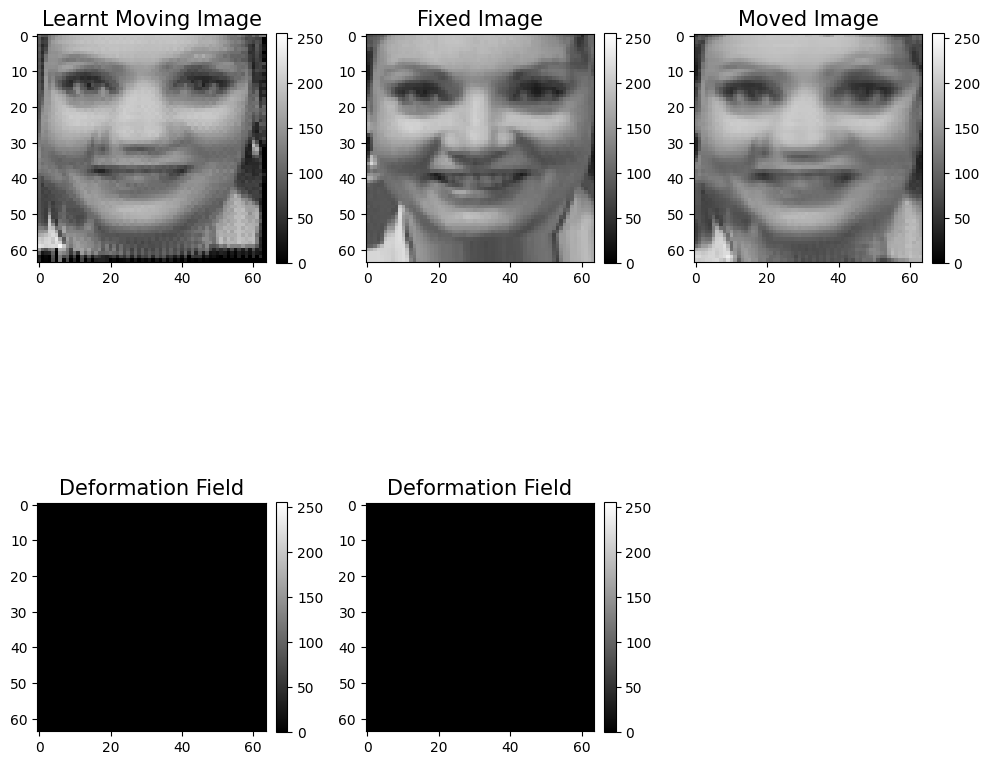

In [ ]:
output_images= [moving.detach()[0,0].to('cpu').numpy(),
               fixed[0,0].to('cpu').numpy(),
               moved[0,0].detach().to('cpu').numpy(),
               ddf[0,0].detach().to('cpu').numpy(),
               ddf[0,1].detach().to('cpu').numpy()]
show_image_list(list_images=output_images,
                list_titles=['Learnt Moving Image','Fixed Image','Moved Image','Deformation Field','Deformation Field'],
                num_cols=3,
                figsize=(10, 10),
                grid=False,
                title_fontsize=15)